# Data Preparation

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.models import load_model
import time

In [133]:
df=pd.read_csv('prices-split-adjusted.csv')

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [135]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


**Open and Close** represent opening and closing prices of the stock per day (when
the markets open and then close).

**High and Low** represent the highest/lowest price of the stock during that day.

**Volume** is the number of stocks traded that day.

In [136]:
df.symbol.value_counts()

KSU     1762
NOC     1762
ORCL    1762
OMC     1762
OKE     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

Pick APPLE

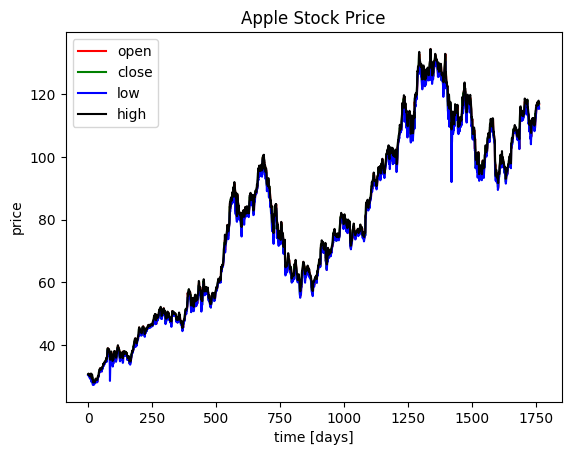

In [137]:
plt.plot(df[df.symbol == 'AAPL'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'AAPL'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'AAPL'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'AAPL'].high.values, color='black', label='high')
plt.title('Apple Stock Price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

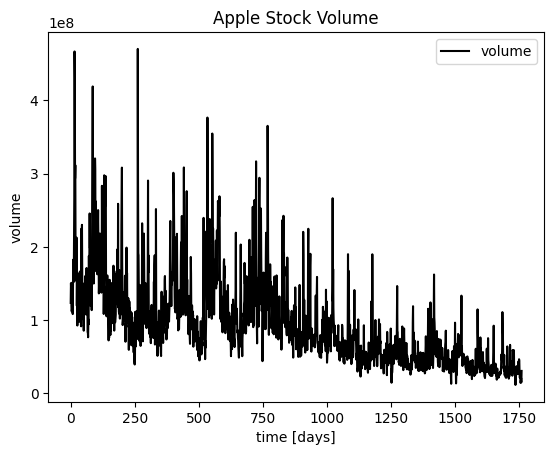

In [138]:
plt.plot(df[df.symbol == 'AAPL'].volume.values, color='black', label='volume')
plt.title('Apple Stock Volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [139]:
# convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Manipulate data

normalize stock data

In [140]:

apple = df[df['symbol'] == 'AAPL']

# Initializing scalers
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()

# Creating a copy of the apple DataFrame and dropping the 'symbol' column
APPL_df = apple.copy()
APPL_df.drop(['symbol'], axis=1, inplace=True)

# Extracting features and target variable
x = APPL_df[['open', 'low', 'high', 'volume']].copy()
y = APPL_df['close'].copy()

# Normalizing the features and target variable
x[['open', 'low', 'high', 'volume']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [141]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762 entries, 254 to 850767
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1762 non-null   float64
 1   low     1762 non-null   float64
 2   high    1762 non-null   float64
 3   volume  1762 non-null   float64
dtypes: float64(4)
memory usage: 68.8 KB


**Use 4 features** (open, low, high, volume) to predict close price.

Form a new dataframe that have 4 features and 1 predictor.

In [142]:
# Converting 'x' to a NumPy array
x = x.values

# Reshaping 'y' to a 1-D array
y = y.reshape(-1)

# Combining 'x' and 'y' into a single NumPy array
dataset = np.column_stack((x, y))

# Now, 'dataset' is a 2D NumPy array where the last column is 'y' (close prices)

Splitting the data (ensure to maintain the time order)

In [143]:
# Splitting the data into training and testing sets
train_size = int(len(dataset) * 0.8)  # using 80% of the data for training
test_size = len(df) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


**Reshape inputs (X) into the 3D format expected by LSTM**

[**batch size** (num of samples), **timesteps** (the amount of time that we want to go back through time), the **number of features** (input dimension)].

In [144]:
time_steps = 20 # choose 20 for daily stock prices (20 trading days in a month)

# a window of historical data points used for predictions

In [145]:
# Create Windowed Dataset for LSTM

def create_dataset(dataset, time_steps):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):  # avoid going out of bounds
        a = dataset[i:(i + time_steps), :-1]  # take the features excluding target (last column in dataset)
        dataX.append(a)
        dataY.append(dataset[i + time_steps, -1])  # take the last column as target
    return np.array(dataX), np.array(dataY)


In [146]:
X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)
# X_train (1389,20,4)

Define the LSTM model

In [149]:
def create_lstm_model(input_shape):
    # Initialize the Sequential model
    d = 0.2
    model = Sequential()

    # First LSTM layer with dropout
    model.add(LSTM(32, input_shape=input_shape, return_sequences=True))  # 32 units (neurons)
    model.add(Dropout(d))   # prevent overfitting by randomly setting a fraction of input units to zero

    # Additional LSTM layers with dropout
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(d))


    # Dense layers with activation functions
    model.add(Dense(16, kernel_initializer="uniform", activation='relu'))


    # Output layer for regression
    model.add(Dense(1, kernel_initializer="uniform", activation='linear'))

    # Compile the model with mean squared error loss and the Adam optimizer
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model

In [157]:
# Assuming each sample in the dataset has a shape of (20, 4)
model = create_lstm_model((20, 4))

# Summary of the model
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20, 32)            4736      
                                                                 
 dropout_25 (Dropout)        (None, 20, 32)            0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 13601 (53.13 KB)
Trainable params: 1360

In [159]:
# Fit the model
# epochs: Number of times to pass over the dataset
# batch_size: Number of samples per gradient update
start_time = time.time()

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# Calculate the total training time
end_time = time.time()  # End the timer
training_time = end_time - start_time
print(f"Training Time: {training_time} seconds")

Epoch 1/100
22/22 [==============================] - 8s 72ms/step - loss: 0.2383 - accuracy: 7.1994e-04 - val_loss: 0.4907 - val_accuracy: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 1s 30ms/step - loss: 0.1426 - accuracy: 7.1994e-04 - val_loss: 0.1714 - val_accuracy: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0663 - accuracy: 7.1994e-04 - val_loss: 0.0893 - val_accuracy: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0518 - accuracy: 7.1994e-04 - val_loss: 0.0686 - val_accuracy: 0.0000e+00
Epoch 5/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0143 - accuracy: 0.0014 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0032 - accuracy: 0.0014 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0026 - accuracy: 0.0014 - val_lo

In [152]:
# Use the trained moedl to make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

11/11 [==============================] - 0s 12ms/step


Inverse data

In [153]:
# 'y_train' and 'y_test' are 1D arrays， reshoae to 2D array for using inverse transform
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Inverse transform the target variables
y_train_original = y_scaler.inverse_transform(y_train)
y_test_original = y_scaler.inverse_transform(y_test)


In [154]:
# Inverse transform the predictions
y_train_predict = y_scaler.inverse_transform(trainPredict)
y_test_predict = y_scaler.inverse_transform(testPredict)

In [155]:
# Calculate root mean squared error
trainScore = mean_squared_error(y_train_original, y_train_predict)
print('Train Score (MSE)', trainScore)

testScore = mean_squared_error(y_test_original, y_test_predict)
print('Test Score (MSE)', testScore)


Train Score (MSE) 4.745012052181694
Test Score (MSE) 7.906565223751612


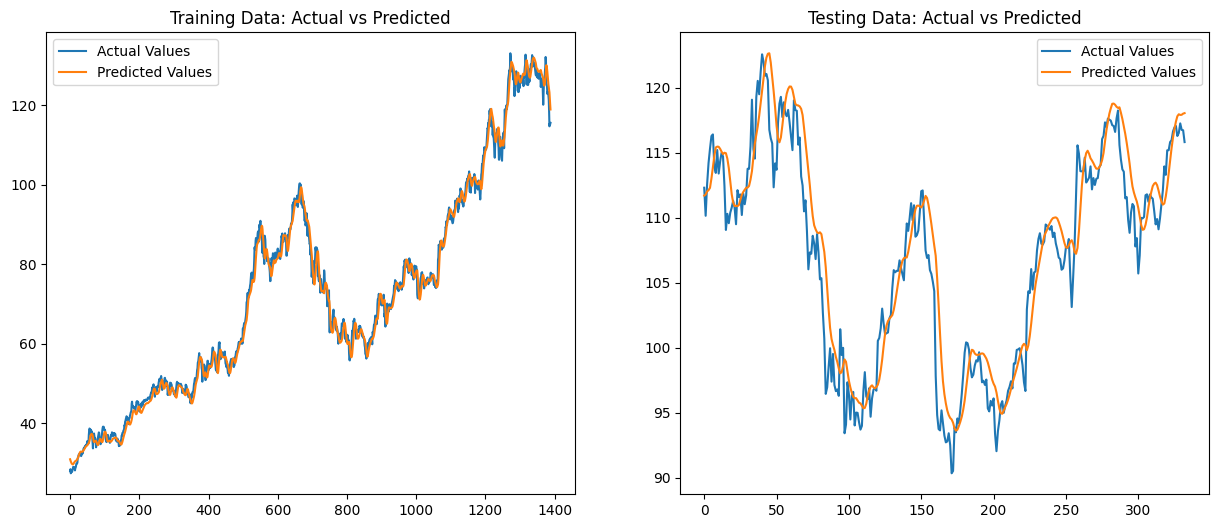

In [156]:
# Plotting the actual vs predicted values for training data
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train_original, label='Actual Values')
plt.plot(y_train_predict, label='Predicted Values')
plt.title('Training Data: Actual vs Predicted')
plt.legend()

# Plotting the actual vs predicted values for testing data
plt.subplot(1, 2, 2)
plt.plot(y_test_original, label='Actual Values')
plt.plot(y_test_predict, label='Predicted Values')
plt.title('Testing Data: Actual vs Predicted')
plt.legend()

plt.show()